# Predicción de la calidad del vino tinto

**Lucas Vallejo Uribe** 

lvallejou@unal.edu.co   
Universidad Nacional de Colombia, Sede Medellín  
Facultad de Minas  
Medellín, Colombia

# Descripción del problema real
Una compañía de vinos desea determinar la calidad de un vino tinto a partir de las medidas obtenidas de diferentes
resultados de laboratorio

# Definición del problema en términos de los datos


Se tiene una muestra de 1599 resultados del análisis fisicoquímico en laboratorio para vinos tintos. Cada registro contiene 12 variables, las cuales corresponden a los resultados de las muestras obtenidas en el laboratorio para diferentes variables.

    1 - fixed acidity
    2 - volatile acidity
    3 - citric acid
    4 - residual sugar
    5 - chlorides
    6 - free sulfur dioxide
    7 - total sulfur dioxide
    8 - density
    9 - pH
    10 - sulphates
    11 - alcohol 
    12 - quality (entre 3 y 8)

En términos de los datos, se desea pronosticar la calidad de un vino tinto (entre 3 - 8, siendo la mayor de mejor calidad) a partir de las 11 variables.

**Fuente de los datos:** https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv

# Librerías

In [1]:
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import numpy as np
#Inicia la librería de gráficos offline en plotly para notebooks en jupyter
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
#SciKitLearn
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.metrics import mean_squared_error

# Funciones

In [2]:
##
## Cantidad de casos
## Función que mimifica la función table() de R
##
def table(x):
    if not isinstance(x, list):
        x = x.values.tolist()
    return {a:x.count(a) for a in set(x)}

# Exploración

In [3]:
#Lectura del DataSet
data = pd.read_csv('winequality-red.csv',';')

In [4]:
data.describe()
#iplot([{"x": [1, 2, 3], "y": [3, 1, 6]}])

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [5]:
data.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [6]:
#Número de registros y número de columnas
data.shape

(1599, 12)

In [7]:
#Rango de la calidad de los vinos
set(data['quality'])

{3, 4, 5, 6, 7, 8}

In [8]:
## Separa la columna quality que es la variable de salida (columna 12)
y = data.quality
## Elimina la columnas 12 "quality" de los datos originales
#X = data.iloc[:,10:11]
X = data.iloc[:,0:11]
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [9]:
histograma = table(y)
histograma

{3: 10, 4: 53, 5: 681, 6: 638, 7: 199, 8: 18}

In [10]:
ejey = list(histograma.values())
ejex = list(histograma.keys())

In [11]:
dataG = [go.Bar(
            x=ejex,
            y=ejey
    )]
iplot({'data':dataG, 
       'layout': {'title': 'Diagrama de Frecuencia Calidad del Vino Tinto'}})

# Metodologías seleccionadas

Se utilizarán las siguientes metodologías, en las que se aplica cross-validationg con kFolds:

* 1.Knn 
* 2.Decision Trees
* 3.Random Forest 
* 4.SVM 
* 5.Gradient Boosting

In [12]:
## Normalización de datos al intervalo [0, 1]
#scaler = MinMaxScaler()
#X_scaled = scaler.fit_transform(X)
X_scaled = preprocessing.scale(X)
X_scaled

array([[-0.52835961,  0.96187667, -1.39147228, ...,  1.28864292,
        -0.57920652, -0.96024611],
       [-0.29854743,  1.96744245, -1.39147228, ..., -0.7199333 ,
         0.1289504 , -0.58477711],
       [-0.29854743,  1.29706527, -1.18607043, ..., -0.33117661,
        -0.04808883, -0.58477711],
       ..., 
       [-1.1603431 , -0.09955388, -0.72391627, ...,  0.70550789,
         0.54204194,  0.54162988],
       [-1.39015528,  0.65462046, -0.77526673, ...,  1.6773996 ,
         0.30598963, -0.20930812],
       [-1.33270223, -1.21684919,  1.02199944, ...,  0.51112954,
         0.01092425,  0.54162988]])

# 1.KNN

Generamos un clasificador partiendo los datos en 40 folds y calculamos la media de la eficiencia para cada valor de K y determinamos el valor óptimo de K

In [13]:
#Partimos los datos usando KFolds
kf = KFold(n_splits=40)
foldMean = []
meanMSE = []
#Iteramos sobre diferentes valores de K para mirar como se comporta la eficiencia del modelo con cada valor de K


MaxK = 100

for k in range(1,MaxK):
    
    #print("\nPara K=" + str(k))
    estadistico = [] # lista para guardar el estadísticos para cada fold, para este caso knn.score = eficiencia del clasificador
    MSE = []
    knn = KNeighborsClassifier(n_neighbors=k,weights='distance')                        #Construcción del clasificador
    
    for train_index, test_index in kf.split(X_scaled):  #Para cada fold generamos los conjuntos de train y test
    #    print("%s %s" % (train, test))

        X_train, X_test = X_scaled[train_index], X_scaled[test_index] 
        y_train, y_test = y[train_index], y[test_index]

        #X_train, X_test = X_scaled[:1000], X_scaled[1000:]  #Test inicial sin kFolds
        #y_train, y_test = y[:1000], y[1000:]
        
        knn.fit(X_train, y_train)
        y_test_pred = knn.predict(X_test)                                #Realizamos la prediccón
        #y_test_pred
        estadistico.append(knn.score(X_test, y_test))         #eficiencia del modelo para cada fold
        MSE.append(mean_squared_error(y_test, y_test_pred))
        #print(knn.score(X_test, y_test))                            
        #accuracy_score(y_true = y_test, y_pred = y_test_pred))#Imprime la eficiencia del modelo,mismo resultado que .score
    foldMean.append(sum(estadistico)/len(estadistico)) #Almaceno la media de la eficiencia en una lista
    meanMSE.append(sum(MSE)/len(MSE))
    #print("La media de la eficiencia es: " + str(foldMean[k - 1])) #devuelve la media de la lista para cada Fold analizado
    #print(estadistico)

In [14]:
comp = {}
comp["Modelos"] = ["Knn","Decision Trees","Random Forest","SVM","Gradient Boosting"]
maxEfi = max(foldMean)
minMSE = min(meanMSE)
print("La eficiencia media más alta es: " + str(maxEfi) + " para K=" + str(foldMean.index(maxEfi)+1)
     + " y un MSE de " + str(meanMSE[foldMean.index(maxEfi)]))
print("El menor MSE es: " + str(minMSE) + " para K=" + str(meanMSE.index(minMSE)+1))
comp["eficiencia"] = [maxEfi]
comp["MSE"] = [meanMSE[foldMean.index(maxEfi)]]

La eficiencia media más alta es: 0.603573717949 para K=69 y un MSE de 0.517051282051
El menor MSE es: 0.505721153846 para K=85


In [15]:
dataG = [go.Scatter(
            x=list(range(1,MaxK)),
            y=foldMean
    )]
iplot({'data':dataG, 
       'layout': {'title': 'Media de la eficiencia para valores de K, con Kfolds=40'}})

In [16]:
#dataG = [go.Scatter(
#            x=list(range(1,MaxK)),
#            y=meanMSE
#    )]
#iplot({'data':dataG, 
#       'layout': {'title': 'MSE para valores de K, con Kfolds=40'}})

trace0 = go.Scatter(
        x=list(range(1,MaxK)),
        y=foldMean,
        name = 'Eficiencia',
        line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 4)
)
trace1 = go.Scatter(
    x=list(range(1,MaxK)),
    y=meanMSE,
    name = 'MSE',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 4,)
)

dataG = [trace0, trace1]

layout = dict(title = 'Eficiencia para valores de K vs MSE',
              xaxis = dict(title = 'max_depth'),
              yaxis = dict(title = 'Eficiencia/MSE'),
              )
fig = dict(data=dataG, layout=layout)
iplot(fig)

El clasificador generó una eficiencia máxima que se aproxima al 60% por lo que se determina que no es el método más óptimo para analizar los datos aunque es mejor que el clasificador basado en la tabla de probabilidad de una tabla de frecuencia.

## Búsqueda de la mejor característica de clasificación y mejor hiperparámetro para K
Iteramos sobre cada característica e identificamos la mejor de estas para clasificar

In [17]:
#X = data.iloc[:,1:2]
#type(X)
#X = X.drop(X.columns[[0, 2, 3, 7]], axis=1)
type(X)

pandas.core.frame.DataFrame

In [18]:
for clasificador in data.columns:
    
    Xc = data[[clasificador]]
    Xc = Xc.as_matrix(columns=None)

    kf = KFold(n_splits=40)
    foldMean = []

    MaxK = 100

    for k in range(1,MaxK):

        estadistico = []
        knn = KNeighborsClassifier(n_neighbors=k,weights='distance')

        for train_index, test_index in kf.split(Xc):

            X_train, X_test = Xc[train_index], Xc[test_index] 
            y_train, y_test = y[train_index], y[test_index]

            knn.fit(X_train, y_train)
            y_test_pred = knn.predict(X_test)
            estadistico.append(knn.score(X_test, y_test))   
            
        foldMean.append(sum(estadistico)/len(estadistico))
        maxEfi = max(foldMean)
    print("La eficiencia media más alta es: " + str(maxEfi) + " para K=" + str(foldMean.index(maxEfi)+1) + " para el clasificador " + clasificador)

La eficiencia media más alta es: 0.441490384615 para K=17 para el clasificador fixed acidity
La eficiencia media más alta es: 0.452836538462 para K=12 para el clasificador volatile acidity
La eficiencia media más alta es: 0.432740384615 para K=35 para el clasificador citric acid
La eficiencia media más alta es: 0.422307692308 para K=57 para el clasificador residual sugar
La eficiencia media más alta es: 0.426009615385 para K=33 para el clasificador chlorides
La eficiencia media más alta es: 0.475352564103 para K=46 para el clasificador free sulfur dioxide
La eficiencia media más alta es: 0.461554487179 para K=21 para el clasificador total sulfur dioxide
La eficiencia media más alta es: 0.430897435897 para K=62 para el clasificador density
La eficiencia media más alta es: 0.422676282051 para K=26 para el clasificador pH
La eficiencia media más alta es: 0.477275641026 para K=55 para el clasificador sulphates
La eficiencia media más alta es: 0.546666666667 para K=95 para el clasificador a

# 2.DecisionTree

### Test inicial para encontrar las mejores características de clasificación

In [19]:
clf = tree.DecisionTreeClassifier(max_depth=5)                 #Se crea el clasificador
X_train, X_test = X_scaled[:1000], X_scaled[1000:]  #Test inicial sin kFolds - Partición de datos
y_train, y_test = y[:1000], y[1000:]
clf = clf.fit(X_train,y_train)                      #Ajuste del modelo con datos de entranamiento
clf.feature_importances_                            #Encontramos las mejores características

array([ 0.03900554,  0.05451406,  0.04529301,  0.04535307,  0.        ,
        0.02922621,  0.1178797 ,  0.05529062,  0.01620705,  0.16633506,
        0.43089569])

In [20]:
XtreeDF = X.drop(X.columns[[0, 1, 2, 3,4,5,7,8]], axis=1)
#X_scaled = X
Xtree = XtreeDF.as_matrix(columns=None)
Xtree

array([[ 34.  ,   0.56,   9.4 ],
       [ 67.  ,   0.68,   9.8 ],
       [ 54.  ,   0.65,   9.8 ],
       ..., 
       [ 40.  ,   0.75,  11.  ],
       [ 44.  ,   0.71,  10.2 ],
       [ 42.  ,   0.66,  11.  ]])

## Se realiza el entrenamieto con kFolds y se analiza el mejor hiperparámetro para max_depth para las caracteristicas más relevantes

In [21]:
#Partimos los datos usando KFolds
kf = KFold(n_splits=40)
foldMean = []
eficiencia = []
meanMSE = []

for depth in range(1,20):
    
    estadistico = [] # lista para guardar el estadístico para cada fold
    MSE = []
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    
    for train_index, test_index in kf.split(Xtree):  

        X_train, X_test = Xtree[train_index], Xtree[test_index] 
        y_train, y_test = y[train_index], y[test_index]
 
        clf.fit(X_train,y_train)
        y_test_pred = clf.predict(X_test)                                #Realizamos la prediccón
        estadistico.append(clf.score(X_test, y_test))         #eficiencia del modelo para cada fold
        MSE.append(mean_squared_error(y_test, y_test_pred))

    foldMean.append(sum(estadistico)/len(estadistico)) #Almaceno la media de la eficiencia en una lista
    maxEfi = max(foldMean)
    eficiencia.append(maxEfi)
    meanMSE.append(sum(MSE)/len(MSE))
    print("La eficiencia media más alta es: " + str(maxEfi) + " para max_depth " + str(depth)
         + " con un MSE=" + str(meanMSE[depth -1 ]))

comp["eficiencia"].append(max(eficiencia))
comp["MSE"].append(meanMSE[eficiencia.index(max(eficiencia))])

La eficiencia media más alta es: 0.532948717949 para max_depth 1 con un MSE=0.627051282051
La eficiencia media más alta es: 0.532948717949 para max_depth 2 con un MSE=0.627051282051
La eficiencia media más alta es: 0.53921474359 para max_depth 3 con un MSE=0.60891025641
La eficiencia media más alta es: 0.579246794872 para max_depth 4 con un MSE=0.554503205128
La eficiencia media más alta es: 0.579246794872 para max_depth 5 con un MSE=0.587099358974
La eficiencia media más alta es: 0.579246794872 para max_depth 6 con un MSE=0.568958333333
La eficiencia media más alta es: 0.579246794872 para max_depth 7 con un MSE=0.604599358974
La eficiencia media más alta es: 0.579246794872 para max_depth 8 con un MSE=0.659038461538
La eficiencia media más alta es: 0.579246794872 para max_depth 9 con un MSE=0.695288461538
La eficiencia media más alta es: 0.579246794872 para max_depth 10 con un MSE=0.756554487179
La eficiencia media más alta es: 0.579246794872 para max_depth 11 con un MSE=0.755961538462

In [22]:
#conda install python-graphviz
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None)   #Generación del árbol de clasificación para exportar a formato PDF
graph = graphviz.Source(dot_data) 
graph.render("RedWineTree")  # Genera un PDF con la gráfica del árbol en el directorio actual

'RedWineTree.pdf'

In [23]:
#Creamos etiquetas para cada una de las clases existentes de vino tinto así:
#3: Muy Malo 4:Malo 5:Regular 6:Bueno 7:Muy bueno 8: Exqusito
target_names = np.array(['Muy Malo','Malo','Regular','Bueno','Muy Bueno','Exquisito'])

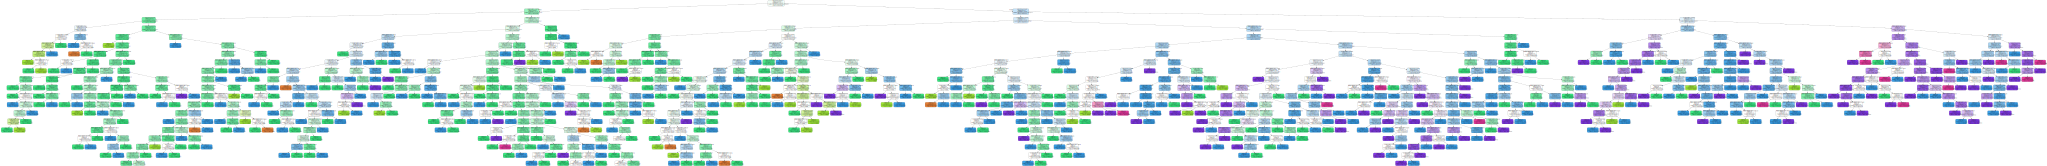

In [24]:
dot_data = tree.export_graphviz(clf, out_file=None,  #Clasificador, sin destino a archivo en disco
                         feature_names=list(XtreeDF.columns.values),  #Nombres de las características
                         class_names=target_names,              #Nombres de las clases target
                         filled=True, rounded=True,             #Propiedades de la gráfica del árbol
                         special_characters=True)                
graph = graphviz.Source(dot_data)                               #Genera la gráfica y la muestra
graph                                                           #Gráfica del árbol

In [25]:
trace0 = go.Scatter(
        x=list(range(1,20)),
        y=eficiencia,
        name = 'Eficiencia',
        line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 4)
)
trace1 = go.Scatter(
    x=list(range(1,20)),
    y=meanMSE,
    name = 'MSE',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 4,)
)

dataG = [trace0, trace1]

layout = dict(title = 'Eficiencia para valores de max_depth y MSE',
              xaxis = dict(title = 'max_depth'),
              yaxis = dict(title = 'Eficiencia/MSE'),
              )
fig = dict(data=dataG, layout=layout)
iplot(fig)

El mejor clasificador para este modelo es de 56% con max_depth=8 que converge al mismo valor si lo seguimos aumentando. Es un clasificador que no mejora mucho el dummy del modelo.

# 3.Random Forest

### Encontramos las mejores características de clasificación

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [27]:
clf = RandomForestClassifier()                 #Se crea el clasificador
X_train, X_test = X_scaled[:1000], X_scaled[1000:]  #Test inicial sin kFolds - Partición de datos
y_train, y_test = y[:1000], y[1000:]
clf = clf.fit(X_train,y_train)                      #Ajuste del modelo con datos de entranamiento
clf.feature_importances_   

array([ 0.08150876,  0.08388557,  0.08408547,  0.06397892,  0.08918514,
        0.06754747,  0.12659418,  0.08211359,  0.0715077 ,  0.10768381,
        0.14190939])

In [28]:
XrfDF = X.drop(X.columns[[0, 1, 2, 3,4,5,7,8]], axis=1)
Xrf = XrfDF.as_matrix(columns=None)
Xrf

array([[ 34.  ,   0.56,   9.4 ],
       [ 67.  ,   0.68,   9.8 ],
       [ 54.  ,   0.65,   9.8 ],
       ..., 
       [ 40.  ,   0.75,  11.  ],
       [ 44.  ,   0.71,  10.2 ],
       [ 42.  ,   0.66,  11.  ]])

### Entrenamos el modelo con las mejores características realizando CrossValidation con KFolds y optimización del hiperparámetro max_depth

In [29]:
#Partimos los datos usando KFolds
kf = KFold(n_splits=40)
foldMean = []
estadistico = [] # lista para guardar el estadísticos para cada fold
eficiencia = []
meanMSE = []

for depth in range(1,20):
    
    clf = RandomForestClassifier(max_depth=depth, random_state=0)
    estadistico = [] # lista para guardar el estadísticos para cada fold
    MSE = []
    
    for train_index, test_index in kf.split(Xrf):  

        X_train, X_test = Xrf[train_index], Xrf[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        clf = clf.fit(X_train,y_train)
        y_test_pred = clf.predict(X_test)                                #Realizamos la prediccón
        estadistico.append(clf.score(X_test, y_test))         #eficiencia del modelo para cada fold
        MSE.append(mean_squared_error(y_test, y_test_pred))

    foldMean.append(sum(estadistico)/len(estadistico)) #Almaceno la media de la eficiencia en una lista
    maxEfi = max(foldMean)
    eficiencia.append(maxEfi)
    meanMSE.append(sum(MSE)/len(MSE))
    print("La eficiencia media más alta es: " + str(maxEfi) + " para max_depth " + str(depth))
comp["eficiencia"].append(max(eficiencia))
comp["MSE"].append(meanMSE[eficiencia.index(max(eficiencia))])

La eficiencia media más alta es: 0.547403846154 para max_depth 1
La eficiencia media más alta es: 0.567355769231 para max_depth 2
La eficiencia media más alta es: 0.567355769231 para max_depth 3
La eficiencia media más alta es: 0.580496794872 para max_depth 4
La eficiencia media más alta es: 0.586121794872 para max_depth 5
La eficiencia media más alta es: 0.594855769231 para max_depth 6
La eficiencia media más alta es: 0.594855769231 para max_depth 7
La eficiencia media más alta es: 0.597291666667 para max_depth 8
La eficiencia media más alta es: 0.597291666667 para max_depth 9
La eficiencia media más alta es: 0.597291666667 para max_depth 10
La eficiencia media más alta es: 0.597291666667 para max_depth 11
La eficiencia media más alta es: 0.597291666667 para max_depth 12
La eficiencia media más alta es: 0.597291666667 para max_depth 13
La eficiencia media más alta es: 0.597291666667 para max_depth 14
La eficiencia media más alta es: 0.597291666667 para max_depth 15
La eficiencia media

In [30]:
dataG = [go.Scatter(
            x=list(range(1,20)),
            y=eficiencia
    )]
iplot({'data':dataG, 
       'layout': {'title': 'Eficiencia para valores de max_depth'}})

In [31]:
trace0 = go.Scatter(
        x=list(range(1,20)),
        y=eficiencia,
        name = 'Eficiencia',
        line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 4)
)
trace1 = go.Scatter(
    x=list(range(1,20)),
    y=meanMSE,
    name = 'MSE',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 4,)
)

dataG = [trace0, trace1]

layout = dict(title = 'Eficiencia para valores de max_depth y MSE',
              xaxis = dict(title = 'max_depth'),
              yaxis = dict(title = 'Eficiencia/MSE'),
              )
fig = dict(data=dataG, layout=layout)
iplot(fig)

# 4.SVM

### Entrenamos el modelo con todas las características realizando CrossValidation con KFolds

In [32]:
from sklearn import svm 
#Partimos los datos usando KFolds
kf = KFold(n_splits=40)
foldMean = []
estadistico = [] # lista para guardar el estadísticos para cada fold, para este caso knn.score = eficiencia del clasificador
eficiencia = []
MSE = []
    
for train_index, test_index in kf.split(X_scaled):  

    X_train, X_test = X_scaled[train_index], X_scaled[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    
    clf = svm.SVC(decision_function_shape='ovo')
    clf = clf.fit(X_train,y_train)
    y_test_pred = clf.predict(X_test)                                #Realizamos la prediccón
    estadistico.append(clf.score(X_test, y_test))         #eficiencia del modelo para cada fold
    MSE.append(mean_squared_error(y_test, y_test_pred))

foldMean.append(sum(estadistico)/len(estadistico)) #Almaceno la media de la eficiencia en una lista
maxEfi = max(foldMean)
print("La eficiencia media más alta es: " + str(maxEfi))

comp["eficiencia"].append(maxEfi)
comp["MSE"].append(MSE[foldMean.index(maxEfi)])

La eficiencia media más alta es: 0.613653846154


In [33]:
trace0 = go.Scatter(
        x=list(range(1,20)),
        y=estadistico,
        name = 'Eficiencia',
        line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 4)
)
trace1 = go.Scatter(
    x=list(range(1,20)),
    y=MSE,
    name = 'MSE',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 4,)
)

dataG = [trace0, trace1]

layout = dict(title = 'Eficiencia para cada fold VS MSE',
              xaxis = dict(title = '#Fold'),
              yaxis = dict(title = 'Eficiencia/MSE'),
              )
fig = dict(data=dataG, layout=layout)
iplot(fig)

# 5.Gradient Boosting

### Entrenamos el modelo con todas las características realizando CrossValidation con KFolds y optimizando los hiperparámetros para el modelo seleccionado

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
#Partimos los datos usando KFolds
kf = KFold(n_splits=40)
foldMean = []
meanMSE = []
eficiencia = []

for depth in range(1,7):

    clf = gbmTree = GradientBoostingClassifier(max_depth=depth)
    estadistico = []
    MSE = []
    
    for train_index, test_index in kf.split(X_scaled):  

        X_train, X_test = X_scaled[train_index], X_scaled[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        clf = clf.fit(X_train,y_train)
        y_test_pred = clf.predict(X_test)                                #Realizamos la prediccón
        estadistico.append(clf.score(X_test, y_test))         #eficiencia del modelo para cada fold
        MSE.append(mean_squared_error(y_test, y_test_pred))

    foldMean.append(sum(estadistico)/len(estadistico)) #Almaceno la media de la eficiencia en una lista
    maxEfi = max(foldMean)
    eficiencia.append(maxEfi)
    meanMSE.append(sum(MSE)/len(MSE))
    print("La eficiencia media más alta es: " + str(maxEfi) + " para max_depth " + str(depth))

comp["eficiencia"].append(max(eficiencia))
comp["MSE"].append(meanMSE[eficiencia.index(max(eficiencia))])

La eficiencia media más alta es: 0.589855769231 para max_depth 1
La eficiencia media más alta es: 0.594230769231 para max_depth 2
La eficiencia media más alta es: 0.594230769231 para max_depth 3
La eficiencia media más alta es: 0.594230769231 para max_depth 4
La eficiencia media más alta es: 0.594230769231 para max_depth 5
La eficiencia media más alta es: 0.594230769231 para max_depth 6


In [35]:
trace0 = go.Scatter(
        x=list(range(1,20)),
        y=eficiencia,
        name = 'Eficiencia',
        line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 4)
)
trace1 = go.Scatter(
    x=list(range(1,20)),
    y=meanMSE,
    name = 'MSE',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 4,)
)

dataG = [trace0, trace1]

layout = dict(title = 'Eficiencia para valores de max_depth y MSE',
              xaxis = dict(title = 'max_depth'),
              yaxis = dict(title = 'Eficiencia/MSE'),
              )
fig = dict(data=dataG, layout=layout)
iplot(fig)

# Compración entre modelos

Durante la ejecución de los modelos se creo el diccionario **comp** donde se almacenaron las métricas de error y de eficiencia, las cuales se presentan en la sgte tabla:

In [36]:
comparacion = pd.DataFrame.from_dict(comp)

In [37]:
comparacion

,MSE,Modelos,eficiencia
0,0.517051,Knn,0.603574
1,0.554503,Decision Trees,0.579247
2,0.541458,Random Forest,0.597292
3,0.600000,SVM,0.613654
4,0.560769,Gradient Boosting,0.594231


Se evidencia que la eficiencia para el modelo SVM y Knn es la mejor, seguida muy de cerca del gradient boosting. Sin embargo ningún clasificador superó el 62%. En otros ejemplos de análisis de la calidad del vino convertían el dataset en clases binarias "Muy Bueno" y "Malo", pero en este ejercicio se quiso desarrollar un clasificador para todas las clases con las que disponía el dataset y los resultados obtenidos se evidencian acá como un problema de clasificación múltiple.